In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import random, copy
from collections import deque
from datetime import datetime
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

In [2]:
SEED_VALUE = 1001
BUFFER_CAPACITY = 1000000
T_LR = 0.001
BUFFER_FILL_MATCH_COUNT = 256
BEST_MATCHES_COUNT = 8
VARIATION_RANGE = 2
GAMMA = 0.995
BATCH_SIZE = 128
RACE_COUNT = 10
NUM_MODEL = 10
NUM_EPOCH = 10
FINAL_RACE_COUNT = 5
RACE_PERCENT = 20
BEST_N = 2

In [3]:
plot_path = "plots/Trainee_Multiplier_Model_1001_CartPole/"

In [4]:
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [5]:
# helper functions
def random_mul(val):
    '''
    gerates random number around 1
    val: deviation from 1
    '''
    return random.uniform(1 - val, 1 + val)

def max_two_index(l):
    m = sorted(l)
    n = m[-1]
    max_index_1 = [x for x in range(len(l)) if l[x] == n]
    o = [x for x in m if x != n]
    if len(o) == 0:
        return sorted(max_index_1)
    else:
        p = o[-1]
        max_index_2 = [x for x in range(len(l)) if l[x] == p]
        return sorted(max_index_1 + max_index_2)

def max_val_index(l):
    m = sorted(l)
    n = m[-1]
    max_index = [x for x in range(len(l)) if l[x] == n]
    return n, max_index[0]

def max_indices(l, length):
    m = list(set(l))
    n = sorted(m, reverse=True)
    o = min(length, len(n))
    p = n[:o]
    q = []
    for i in range(len(l)):
        for el in p:
            if el == l[i]:
                q.append(i)
    return sorted(list(set(q)))

def good_val_indices(l, percent, rank):
    m = max(l)
    n = min(l)
    o = m - (m - n) * (percent / 100)
    p1 = [i for i in range(len(l)) if l[i] == m]
    if len(p1) >= rank:
        return sorted(p1[:rank])
    q1 = [el for el in l if el != m]
    m1 = max(q1)
    p2 = [i for i in range(len(l)) if l[i] == m1][0]
    p = [i for i in range(len(l)) if o <= l[i] <= m]
    q = list(set(p).intersection(set([p2, p1[0]])))
    return sorted(q)

def biased_mean(l):
    if len(l) < 100:
        return 0
    else:
        return sum(l) / len(l)

In [6]:
class Trainee:
    def __init__(self, state_dim):
        self.state_dim = state_dim
        self.model = self.nn_model()
        self.opt = tf.keras.optimizers.Adam(T_LR)

    def nn_model(self):
        inputs = Input((self.state_dim,))
        d1 = Dense(32, activation="relu")(inputs)
        d2 = Dense(32, activation="relu")(d1)
        outputs = Dense(1, activation="sigmoid")(d2)
        return tf.keras.Model(inputs, outputs)

    def get_action(self, state):
        state = np.array(state)
        predicted = self.model.predict(state)
        return 1 if predicted > 0.5 else 0

    def train(self, states, r_grads):
        r_grads = tf.convert_to_tensor(r_grads, dtype=tf.float32)
        with tf.GradientTape() as tape:
            x = self.model(states, training=True)
            grads = tape.gradient(x, self.model.trainable_variables, r_grads)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))

In [7]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def store(self, info):
        self.buffer.append(info)

    def sample(self):
        sample = random.sample(self.buffer, BATCH_SIZE)
        states, r_grads = map(np.asarray, zip(*sample))
        states = np.array(states).reshape(BATCH_SIZE, -1)
        r_grads = np.array(r_grads).reshape(BATCH_SIZE, -1)
        return states, r_grads

    def size(self):
        return len(self.buffer)

In [8]:
class Agent:
    def __init__(self, env_name):
        self.env = gym.make(env_name)
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.trs = [Trainee(self.state_dim) for _ in range(NUM_MODEL)]
        self.buffer = ReplayBuffer(BUFFER_CAPACITY)
        self.best_model = self.trs[0]

    def runners(self, model_list, weights, indices):
        delisted_indices = [i for i in range(NUM_MODEL) if i not in indices]
        for i in delisted_indices:
            updated_weights = [x * random_mul(VARIATION_RANGE) for x in weights]
            model_list[i].model.set_weights(updated_weights)
        return model_list

    def buffer_filler(self, best_model, index):
        temp_buffer_list = []
        ep_return_list = []
        for _ in range(BUFFER_FILL_MATCH_COUNT):
            ep_return = 0
            temp_buffer = []
            return_t = 0
            done = False
            state = self.env.reset()
            while not done:
                action = best_model.get_action([state])
                next_state, reward, done, _ = self.env.step(action)
                state = next_state
                ep_return += reward
                r_grad = - (reward + (1 - GAMMA) * return_t) / (return_t + 0.1)
                return_t = reward + GAMMA * return_t
                temp_buffer.append([state, r_grad])
            ep_return_list.append(ep_return)
            temp_buffer_list.append(temp_buffer)
        imp_index = max_indices(ep_return_list, BEST_MATCHES_COUNT)
        num_stored = 0
        for i in imp_index:
            for x in temp_buffer_list[i]:
                num_stored += 1
                self.buffer.store(x)
        for_plot = [ep_return_list[i] for i in imp_index]
        plt.plot(for_plot)
        plt.title(f"Buffer input Returns of race {index} with injection {num_stored}")
        plt.savefig(plot_path + f"buffer_returns_{index}.png")
        plt.show()
        
    def train_from_buffer(self, model_list):
        for m in model_list:
            for _ in range(NUM_EPOCH):
                states, r_grads = self.buffer.sample()
                m.train(states, r_grads)
    
    def race(self, model_list, index):
        race_avg = [0] * NUM_MODEL
        for i in range(NUM_MODEL):
            reward_sum = 0
            for _ in range(RACE_COUNT):
                done = False
                state = self.env.reset()
                while not done:
                    action = model_list[i].get_action([state])
                    next_state, reward, done, _ = self.env.step(action)
                    state = next_state
                    reward_sum += reward
            race_avg[i] = reward_sum / RACE_COUNT
        plt.plot(race_avg)
        plt.title(f"Racer Returns of race {index}")
        plt.savefig(plot_path + f"race_avg_returns_{index}.png")
        plt.show()
        return race_avg

    def train(self):
        i = 0
        for_plot = []
        ma = []
        model_list = self.trs
        while i < FINAL_RACE_COUNT and biased_mean(ma) < 200:
            print(f"Starting filling buffer: {i}...")
            self.buffer_filler(self.best_model, i)
            print("Training starts...")
            self.train_from_buffer(model_list)
            print(f"Buufer size: {self.buffer.size()}, Starting race {i}")
            race_avg = self.race(model_list, i)
            print("Race complete!")
            max_ep_reward, best_model_index = max_val_index(race_avg)
            good_model_indices = good_val_indices(race_avg, RACE_PERCENT, BEST_N)
            self.best_model = self.trs[best_model_index]
            for_plot.append(max_ep_reward)
            ma = for_plot[-(len(for_plot) if len(for_plot) < 100 else 100):]
            print(f"At race {i}, finalist model is Model#({best_model_index}) with episode reward {max_ep_reward}")
            print(f"carrying following Model numbers: {good_model_indices}")
            new_weights = model_list[best_model_index].model.get_weights()
            model_list = self.runners(model_list, new_weights, good_model_indices)
            i += 1
        plt.plot(for_plot)
        plt.title("Final Return Plot")
        plt.savefig(plot_path + "Final_Returns.png")
        plt.show()
        
    def get_final_weights(self):
        return self.best_model.model.get_weights()

Starts at 21-12-09, 22:37:14
Starting filling buffer: 0...


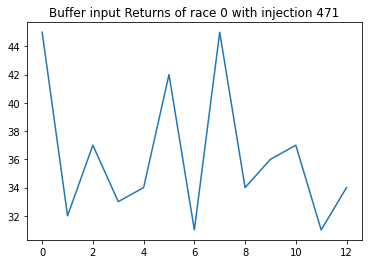

Training starts...
Buufer size: 471, Starting race 0


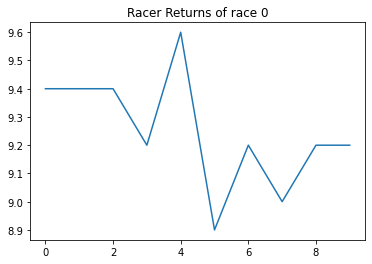

Race complete!
At race 0, finalist model is Model#(4) with episode reward 9.6
carrying following Model numbers: [4]
Starting filling buffer: 1...


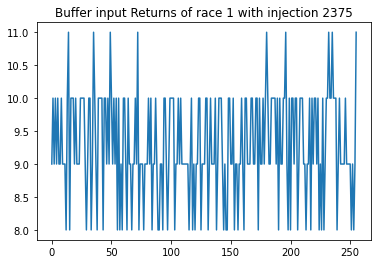

Training starts...
Buufer size: 2846, Starting race 1


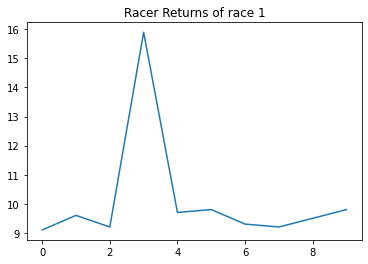

Race complete!
At race 1, finalist model is Model#(3) with episode reward 15.9
carrying following Model numbers: [3]
Starting filling buffer: 2...


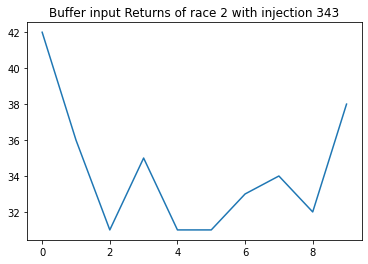

Training starts...
Buufer size: 3189, Starting race 2


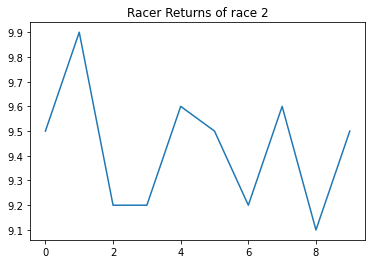

Race complete!
At race 2, finalist model is Model#(1) with episode reward 9.9
carrying following Model numbers: [1]
Starting filling buffer: 3...


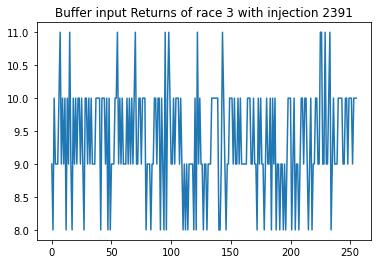

Training starts...
Buufer size: 5580, Starting race 3


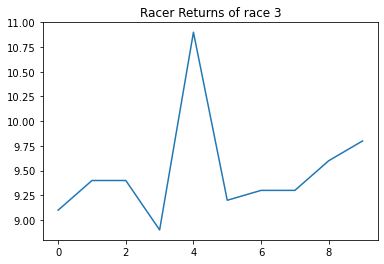

Race complete!
At race 3, finalist model is Model#(4) with episode reward 10.9
carrying following Model numbers: [4]
Starting filling buffer: 4...


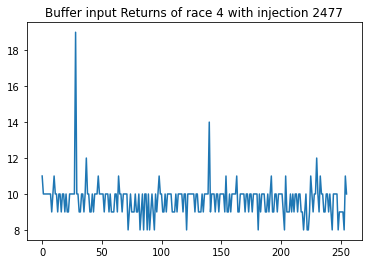

Training starts...
Buufer size: 8057, Starting race 4


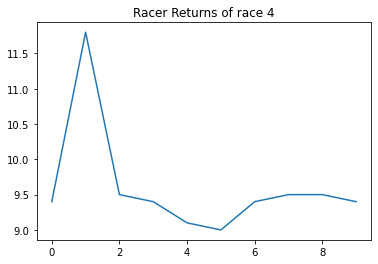

Race complete!
At race 4, finalist model is Model#(1) with episode reward 11.8
carrying following Model numbers: [1]


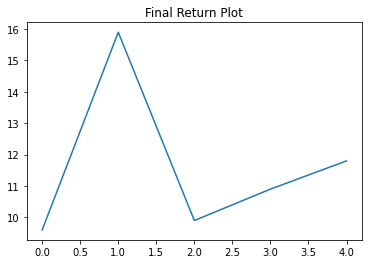

Ends at 21-12-09, 23:01:00


In [9]:
a = Agent("CartPole-v1")
print(f"Starts at {datetime.now().strftime('%y-%m-%d, %H:%M:%S')}")
a.train()
print(f"Ends at {datetime.now().strftime('%y-%m-%d, %H:%M:%S')}")